In [1]:
import warnings

warnings.filterwarnings('ignore')

from jaqs_fxdayu.data.dataservice import LocalDataService
ds = LocalDataService()
from time import time
## 加freq参数

start = time()
path = r'/min_data/VnTrader_1Min_Db'
props = {'fields': 'open,high,low,close,volume','symbol': 'BTCUSDT:binance', 'freq': '4H',
         'start_date':20180801000000}

Time_dict = ds.bar_reader(path,props)
print(time()-start)

data1H = Time_dict.set_index('datetime')

from jaqs_fxdayu.data.hf_dataview import HFDataView

dv1H = HFDataView()
dv1H.create_init_dv(Time_dict.set_index(["trade_date","symbol"]))
#大阳线
import matplotlib.pyplot as plt
import mpl_finance as mpf

def draw_candle(candle, scatterX, scatterY):
    fig, (ax, ax1) = plt.subplots(2,1,sharex=True, figsize=(18,10))
    ax.grid(True)
    mpf.candlestick_ohlc(ax, candle, width=0.3, colorup='r', colordown='g',alpha=1.0)
    ax.scatter(scatterX, scatterY, color='b', s=100, marker='^')
    ax.xaxis_date ()
    ax1.bar(data1H.index, data1H.volume)
    plt.show()

4.2205727100372314
Initialize dataview success.


In [2]:
Big_Up = dv1H.add_formula('Big_Up','If((close/open>1.02) && (high/low<(close/open+0.02)), 100, 0)', add_data=True)

In [3]:
Big_Up[Big_Up['BTCUSDT:binance']==100]

symbol,BTCUSDT:binance
trade_date,
20180828040000,100.0
20180831040000,100.0
20180909160000,100.0


In [4]:
dataBigUp = dv1H.get_ts('Big_Up', date_type='datetime')

In [5]:
dataBigUp[dataBigUp['BTCUSDT:binance']==100].index

DatetimeIndex(['2018-08-28 04:00:00', '2018-08-31 04:00:00',
               '2018-09-09 16:00:00'],
              dtype='datetime64[ns]', name='trade_date', freq=None)

In [6]:
scatterBigUpX = dataBigUp[dataBigUp['BTCUSDT:binance']==100].index

In [7]:
scatterBigUpY = data1H.loc[scatterBigUpX].low-100

In [8]:
#设置candle
from matplotlib.pylab import date2num

data1H['candleTime'] = list(map(date2num, data1H.index))
candle = data1H.reindex_axis(["candleTime", "open", "high", "low", "close"], 1).values

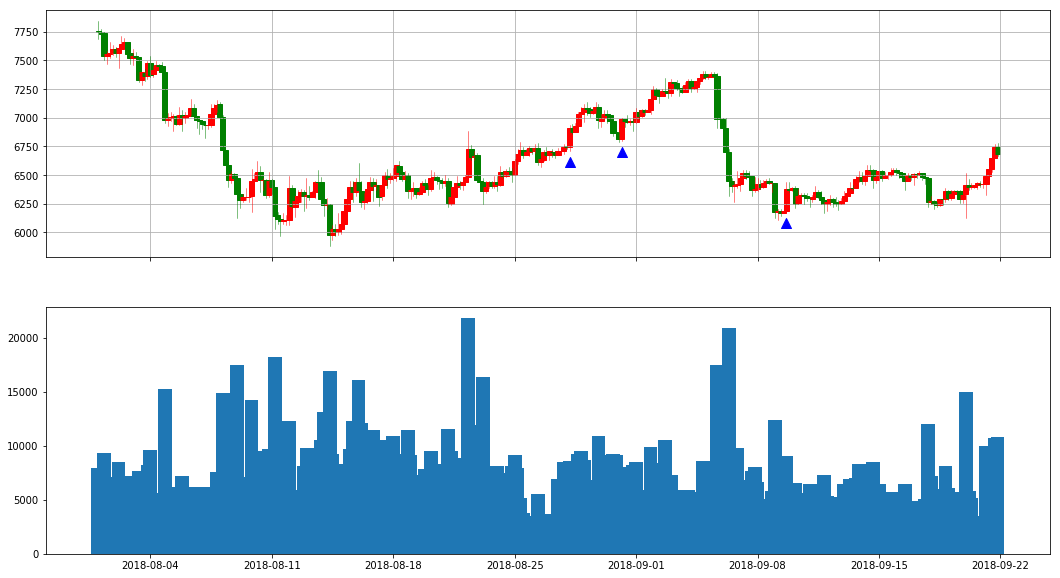

In [9]:
draw_candle(candle, scatterBigUpX, scatterBigUpY)

#大阳线 找到符合设定的大阳线条件的数据做出蜡烛图，判断比特币汇率变化的反转信号和持续信号，观察变化趋势。可以看到几次预测的效果较好，大阳线反噬大阴线且之后价格在一段时间内上升。
#在大阳线反噬大阴线的时候进场（做多），反之，退场（做空）。

In [18]:
from jaqs_fxdayu.data.dataservice import LocalDataService
ds = LocalDataService()
from time import time
import pandas as pd
## 加freq参数

start = time()
path = r'/min_data/VnTrader_1Min_Db'
props = {'fields': 'open,high,low,close,volume','symbol': \
         'BTCUSDT:binance',
         'freq': '1H',
         'start_date':20180101000000}

Time_dict = ds.bar_reader(path,props)

from jaqs_fxdayu.data.hf_dataview import HFDataView
dv = HFDataView()

dv.create_init_dv(Time_dict.set_index(["trade_date","symbol"]))

Initialize dataview success.


In [19]:
import matplotlib.pyplot as plt

def plot_chart(close,alpha):
    fig,(ax,ax1) = plt.subplots(2,1,sharex=True, figsize=(15,8))
    ax.plot(close.iloc[-250:])
    ax1.plot(alpha.iloc[-250:])
    # plt.savefig('good')
    plt.show()

In [20]:
#A 1
def RankPct(df):
    return df.rank(axis=1, pct=True)

In [21]:
alpha1=dv.add_formula('alpha1_C','RankPct(Ts_Argmax(SignedPower(If(Return(close,1)<0, StdDev(Return(close,1),20),close),2),5))',add_data=True, register_funcs={'RankPct':RankPct})

D:\python\Anaconda_\lib\site-packages\jaqs\data\py_expression_eval.py:486: RuntimeWarning: invalid value encountered in less
  res = arr < brr
D:\python\Anaconda_\lib\site-packages\jaqs\data\py_expression_eval.py:434: RuntimeWarning: invalid value encountered in sign
  signs = np.sign(x)
D:\python\Anaconda_\lib\site-packages\jaqs_fxdayu\data\signal_function_mod.py:78: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
  return df.rolling(window).apply(np.argmax) + 1


In [22]:
alpha1_change = dv.add_formula('alpha1_C','Ts_Argmax(SignedPower(If(Return(close,1)<0, StdDev(Return(close,1),20),close),2),5)',add_data=True, register_funcs={'RankPct':RankPct})

Field [alpha1_C] is overwritten.


D:\python\Anaconda_\lib\site-packages\jaqs\data\py_expression_eval.py:486: RuntimeWarning: invalid value encountered in less
  res = arr < brr
D:\python\Anaconda_\lib\site-packages\jaqs\data\py_expression_eval.py:434: RuntimeWarning: invalid value encountered in sign
  signs = np.sign(x)
D:\python\Anaconda_\lib\site-packages\jaqs_fxdayu\data\signal_function_mod.py:78: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
  return df.rolling(window).apply(np.argmax) + 1


In [23]:
alpha1_plot = dv.get_ts('alpha1_C', date_type='datetime')
close = dv.get_ts('close', date_type='datetime')

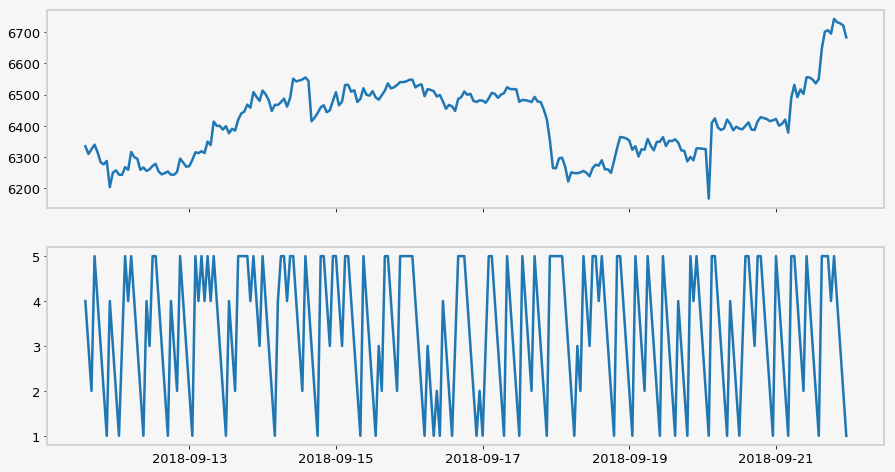

In [24]:
plot_chart(close, alpha1_plot)

#用alpha1因子来研究所选取的因子与价格之间的关系，从而做出假设，标记进出场信号。
#第一张图用收盘价表示价格图变化趋势，第二张图是alpha1因子在不同时间的数值变化趋势。可以看出alpha1因子和收盘价变动趋势相似，因此选取的alpha1因子是较好的。
进出场信号：alpha1因子由小变大时进场（做多），由大变小时退场（做空）。

# 6、将你的其中一个假设落实，如果能完成两个更好，但不强求

利用TimingSignal最后输出long、short、long_short这三个绩效表出来


In [35]:
from jaqs_fxdayu.data.dataservice import LocalDataService
ds = LocalDataService()
from time import time
import pandas as pd
## 加freq参数

start = time()
path = r'/min_data/VnTrader_1Min_Db'
props = {'fields': 'open,high,low,close,volume','symbol': \
         'BTCUSDT:binance',
         'freq': '1H',
         'start_date':20180101000000}

Time_dict = ds.bar_reader(path,props)

from jaqs_fxdayu.data.hf_dataview import HFDataView
dv = HFDataView()

dv.create_init_dv(Time_dict.set_index(["trade_date","symbol"]))

Initialize dataview success.


In [36]:
import matplotlib.pyplot as plt

def plot_chart(close,alpha):
    fig,(ax,ax1) = plt.subplots(2,1,sharex=True, figsize=(15,8))
    ax.plot(close.iloc[-250:])
    ax1.plot(alpha.iloc[-250:])
    # plt.savefig('good')
    plt.show()

In [37]:
#A 1
def RankPct(df):
    return df.rank(axis=1, pct=True)

In [38]:
alpha1=dv.add_formula('alpha1_C','RankPct(Ts_Argmax(SignedPower(If(Return(close,1)<0, StdDev(Return(close,1),20),close),2),5))',add_data=True, register_funcs={'RankPct':RankPct})

D:\python\Anaconda_\lib\site-packages\jaqs\data\py_expression_eval.py:486: RuntimeWarning: invalid value encountered in less
  res = arr < brr
D:\python\Anaconda_\lib\site-packages\jaqs\data\py_expression_eval.py:434: RuntimeWarning: invalid value encountered in sign
  signs = np.sign(x)
D:\python\Anaconda_\lib\site-packages\jaqs_fxdayu\data\signal_function_mod.py:78: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
  return df.rolling(window).apply(np.argmax) + 1


In [39]:
alpha1_change = dv.add_formula('alpha1_C','Ts_Argmax(SignedPower(If(Return(close,1)<0, StdDev(Return(close,1),20),close),2),5)',add_data=True, register_funcs={'RankPct':RankPct})

Field [alpha1_C] is overwritten.


D:\python\Anaconda_\lib\site-packages\jaqs\data\py_expression_eval.py:486: RuntimeWarning: invalid value encountered in less
  res = arr < brr
D:\python\Anaconda_\lib\site-packages\jaqs\data\py_expression_eval.py:434: RuntimeWarning: invalid value encountered in sign
  signs = np.sign(x)
D:\python\Anaconda_\lib\site-packages\jaqs_fxdayu\data\signal_function_mod.py:78: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
  return df.rolling(window).apply(np.argmax) + 1


In [40]:
alpha1_plot = dv.get_ts('alpha1_C', date_type='datetime')
close = dv.get_ts('close', date_type='datetime')

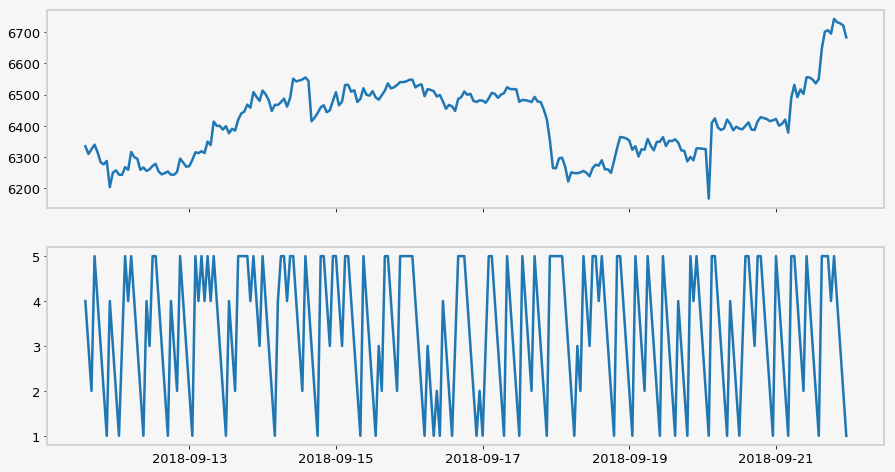

In [41]:
plot_chart(close, alpha1_plot)

In [42]:
# 1、定义calcuate对均线进行打分
import talib as ta
import numpy as np
import pandas as pd

def calculate(alpha, timePeriod):
    mas = ta.MA(alpha.iloc[:,0].values, timePeriod)
    mal = ta.MA(alpha.iloc[:,0].values, 5*timePeriod)
    df = pd.DataFrame({'long': mal, 'short': mas}, index=alpha.index).dropna()
    df['direction'] = list(map(lambda s, l: 1 if s > l else 0, df['short'], df['long']))
    return df['direction']

In [43]:
# signalDf
dvAlpha = dv.get_ts('alpha1_C',date_type='datetime').dropna()
x = np.array(range(1,21,1))
signalDf = pd.DataFrame({t: calculate(dvAlpha, t) for t in x})

In [44]:
#2、信号的加总相乘
signalDf['signal'] = pd.Series({name: true.sum()*5 for name, true in signalDf.iterrows()}) 

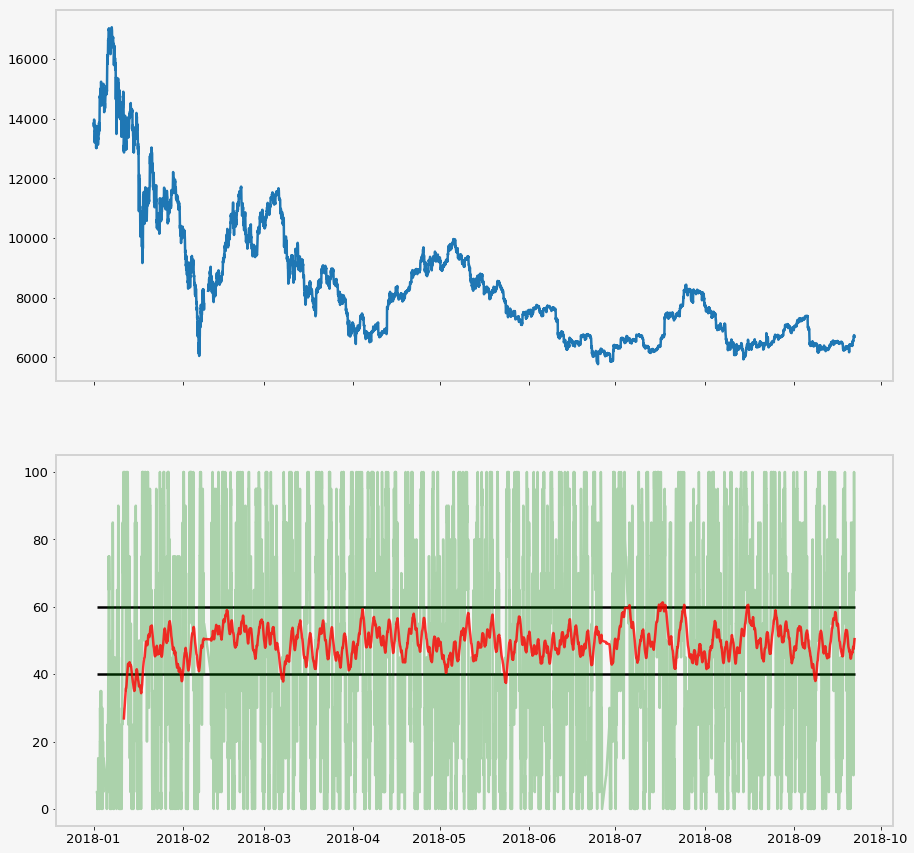

In [45]:
# 3、绘图观察
import matplotlib.pyplot as plt
from talib import abstract

fig, (ax,ax1) = plt.subplots(2,1,sharex=True, figsize=(15,15))
ax.plot(dv.get_ts('close',date_type='datetime'))
ax1.plot(signalDf['signal'], 'g', alpha=0.3)
ax1.plot(abstract.EMA(signalDf,200,price='signal'), 'r', alpha=0.8)
ax1.hlines(60, signalDf['signal'].index[0], signalDf['signal'].index[-1])
ax1.hlines(40, signalDf['signal'].index[0], signalDf['signal'].index[-1])
plt.show()

In [46]:
 #4、定义信号事件
def signalAppend(signalDf):
    signalDf['time'] = signalDf.index
    signalDf["trade_date"] = signalDf['time'].apply(lambda x:int(x.strftime(format="%Y-%m-%d %H:%M:%S").replace("-","").replace(":","").replace(" ","")))
    signalDf["symbol"] = "BTCUSDT:binance"
    signalDf = signalDf.set_index(["trade_date","symbol"])
    signalSe = signalDf.signal.unstack()
    dv.append_df(signalSe,'signalSe')
signalAppend(signalDf)

In [47]:
# 5、设定进出场条件
long = dv.add_formula('long','If((signalSe>=60) && (Delay(signalSe,1)<60), 2, 0)', add_data=True)
short = dv.add_formula('short','If((signalSe<=40) && (Delay(signalSe,1)>40), -2, 0)', add_data=True)
closeLong = dv.add_formula('closeLong','If(short==-2,1,0)', add_data=True)
closeShort = dv.add_formula("closeShort",'If(long==2,-1,0)', add_data=True)

D:\python\Anaconda_\lib\site-packages\jaqs\data\py_expression_eval.py:495: RuntimeWarning: invalid value encountered in greater_equal
  res = arr >= brr
D:\python\Anaconda_\lib\site-packages\jaqs\data\py_expression_eval.py:486: RuntimeWarning: invalid value encountered in less
  res = arr < brr
D:\python\Anaconda_\lib\site-packages\jaqs\data\py_expression_eval.py:504: RuntimeWarning: invalid value encountered in less_equal
  res = arr <= brr
D:\python\Anaconda_\lib\site-packages\jaqs\data\py_expression_eval.py:477: RuntimeWarning: invalid value encountered in greater
  res = arr > brr


In [48]:
#6、计算绩效
from jaqs_fxdayu.research import TimingDigger

tdMaStatistic = TimingDigger(output_folder=".", output_format='pdf',signal_name='MaStatistic')

def TimingSignal(td, dv, mhp=None,sl=None,sp=None):
    # step 1：实例化TimingDigger 通过output_folder和output_format指定测试报告的输出路径和输出格式，通过signal_name指定绩效文件名称


    #多空分别计算一遍 输出汇总结果
    td.process_signal(
        enter_signal=dv.get_ts("long"),
        exit_signal=dv.get_ts("closeLong"),
        sig_type="long",  # 信号类型 long
        price=dv.get_ts("close"),
        max_holding_period=mhp,  # 最大持有天数 可为空
        stoploss=-sl,  # 止损百分比 负数 可为空
        stopprofit=sp,  # 止盈百分比 正数 可为空
    )

    td.process_signal(
        enter_signal=dv.get_ts("short"),
        exit_signal=dv.get_ts("closeShort"),
        sig_type="short",  # 信号类型 short
        price=dv.get_ts("close"),
        max_holding_period=mhp,  # 最大持有天数 可为空
        stoploss=-sl,  # 止损百分比 负数 可为空
        stopprofit=sp,  # 止盈百分比 正数 可为空
    )
TimingSignal(tdMaStatistic, dv, 100, 0.15, 0.7)

D:\python\Anaconda_\lib\site-packages\jaqs_fxdayu\research\timingdigger\digger.py:58: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
  return x.loc[exit_pos[x.name]].values


Nan Data Count (should be zero) : 0;  Percentage of effective data: 5%
Nan Data Count (should be zero) : 0;  Percentage of effective data: 6%


In [49]:
tdMaStatistic.create_event_report(sig_type="long")

*****-Summary-*****
Event Analysis
                        win     loss      all
t-stat                8.817  -12.221    0.347
p-value               0.000    0.000    0.729
mean                  0.023   -0.018    0.001
std                   0.033    0.021    0.034
info_ratio            0.706   -0.896    0.019
skewness              3.187   -2.421    1.606
kurtosis             12.956    7.027   10.019
pct5                  0.001   -0.065   -0.043
pct25                 0.003   -0.022   -0.014
pct50                 0.011   -0.012   -0.002
pct75                 0.029   -0.005    0.009
pct95                 0.095   -0.001    0.047
occurance           157.000  187.000  344.000
win_ratio               NaN      NaN    0.456
win_mean/loss_mean      NaN      NaN    1.267


In [50]:
tdMaStatistic.create_event_report(sig_type="short")

*****-Summary-*****
Event Analysis
                        win     loss      all
t-stat                8.248  -12.115    1.676
p-value               0.000    0.000    0.094
mean                  0.030   -0.016    0.003
std                   0.046    0.019    0.040
info_ratio            0.665   -0.824    0.087
skewness              3.456   -3.709    2.883
kurtosis             15.387   21.283   18.811
pct5                  0.001   -0.044   -0.039
pct25                 0.005   -0.021   -0.013
pct50                 0.014   -0.010   -0.002
pct75                 0.035   -0.004    0.009
pct95                 0.102   -0.001    0.073
occurance           155.000  217.000  372.000
win_ratio               NaN      NaN    0.417
win_mean/loss_mean      NaN      NaN    1.931


In [51]:
tdMaStatistic.create_event_report(sig_type="long_short")#同时计算多空头信号的绩效

*****-Summary-*****
Event Analysis
                        win     loss      all
t-stat               11.824  -17.192    1.518
p-value               0.000    0.000    0.129
mean                  0.027   -0.017    0.002
std                   0.040    0.020    0.037
info_ratio            0.670   -0.856    0.057
skewness              3.553   -3.045    2.459
kurtosis             17.010   13.566   16.592
pct5                  0.001   -0.056   -0.041
pct25                 0.004   -0.021   -0.013
pct50                 0.014   -0.011   -0.002
pct75                 0.030   -0.005    0.009
pct95                 0.101   -0.001    0.059
occurance           312.000  404.000  716.000
win_ratio               NaN      NaN    0.436
win_mean/loss_mean      NaN      NaN    1.581


#对第二个假设进行验证，检验alpha1因子。信号加总相乘后，60分以上做多，40分以下做空。

#EOS测试

In [52]:
from jaqs_fxdayu.data.dataservice import LocalDataService
ds = LocalDataService()
from time import time
import pandas as pd
## 加freq参数

start = time()
path = r'/min_data/VnTrader_1Min_Db'
props = {'fields': 'open,high,low,close,volume','symbol': \
         'EOSUSDT:binance',
         'freq': '1H',
         'start_date':20180101000000}

Time_dict = ds.bar_reader(path,props)

from jaqs_fxdayu.data.hf_dataview import HFDataView
dv = HFDataView()

dv.create_init_dv(Time_dict.set_index(["trade_date","symbol"]))

Initialize dataview success.


In [53]:
import matplotlib.pyplot as plt

def plot_chart(close,alpha):
    fig,(ax,ax1) = plt.subplots(2,1,sharex=True, figsize=(15,8))
    ax.plot(close.iloc[-250:])
    ax1.plot(alpha.iloc[-250:])
    # plt.savefig('good')
    plt.show()

In [54]:
#A 1
def RankPct(df):
    return df.rank(axis=1, pct=True)

In [55]:
alpha1=dv.add_formula('alpha1_C','RankPct(Ts_Argmax(SignedPower(If(Return(close,1)<0, StdDev(Return(close,1),20),close),2),5))',add_data=True, register_funcs={'RankPct':RankPct})

D:\python\Anaconda_\lib\site-packages\jaqs\data\py_expression_eval.py:486: RuntimeWarning: invalid value encountered in less
  res = arr < brr
D:\python\Anaconda_\lib\site-packages\jaqs\data\py_expression_eval.py:434: RuntimeWarning: invalid value encountered in sign
  signs = np.sign(x)
D:\python\Anaconda_\lib\site-packages\jaqs_fxdayu\data\signal_function_mod.py:78: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
  return df.rolling(window).apply(np.argmax) + 1


In [56]:
alpha1_change = dv.add_formula('alpha1_C','Ts_Argmax(SignedPower(If(Return(close,1)<0, StdDev(Return(close,1),20),close),2),5)',add_data=True, register_funcs={'RankPct':RankPct})

Field [alpha1_C] is overwritten.


D:\python\Anaconda_\lib\site-packages\jaqs\data\py_expression_eval.py:486: RuntimeWarning: invalid value encountered in less
  res = arr < brr
D:\python\Anaconda_\lib\site-packages\jaqs\data\py_expression_eval.py:434: RuntimeWarning: invalid value encountered in sign
  signs = np.sign(x)
D:\python\Anaconda_\lib\site-packages\jaqs_fxdayu\data\signal_function_mod.py:78: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
  return df.rolling(window).apply(np.argmax) + 1


In [57]:
alpha1_plot = dv.get_ts('alpha1_C', date_type='datetime')
close = dv.get_ts('close', date_type='datetime')

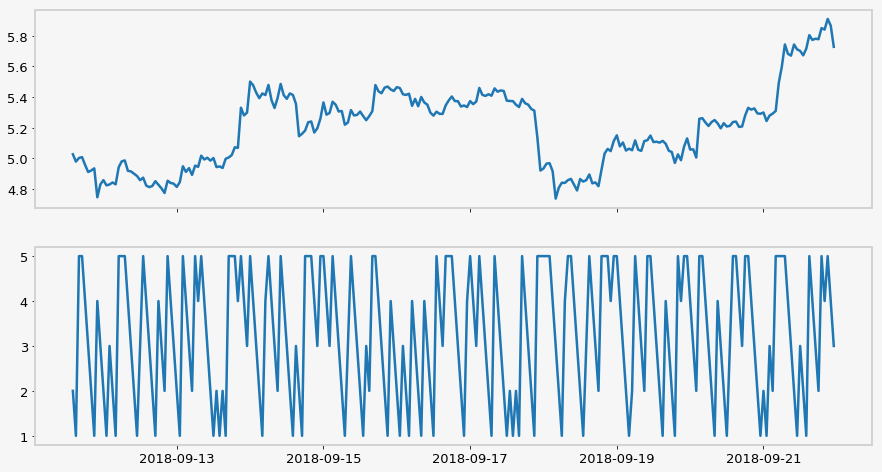

In [58]:
plot_chart(close, alpha1_plot)

In [59]:
# 1、定义calcuate对均线进行打分
import talib as ta
import numpy as np
import pandas as pd

def calculate(alpha, timePeriod):
    mas = ta.MA(alpha.iloc[:,0].values, timePeriod)
    mal = ta.MA(alpha.iloc[:,0].values, 5*timePeriod)
    df = pd.DataFrame({'long': mal, 'short': mas}, index=alpha.index).dropna()
    df['direction'] = list(map(lambda s, l: 1 if s > l else 0, df['short'], df['long']))
    return df['direction']

In [60]:
# signalDf
dvAlpha = dv.get_ts('alpha1_C',date_type='datetime').dropna()
x = np.array(range(1,21,1))
signalDf = pd.DataFrame({t: calculate(dvAlpha, t) for t in x})

In [61]:
#2、信号的加总相乘
signalDf['signal'] = pd.Series({name: true.sum()*5 for name, true in signalDf.iterrows()}) 

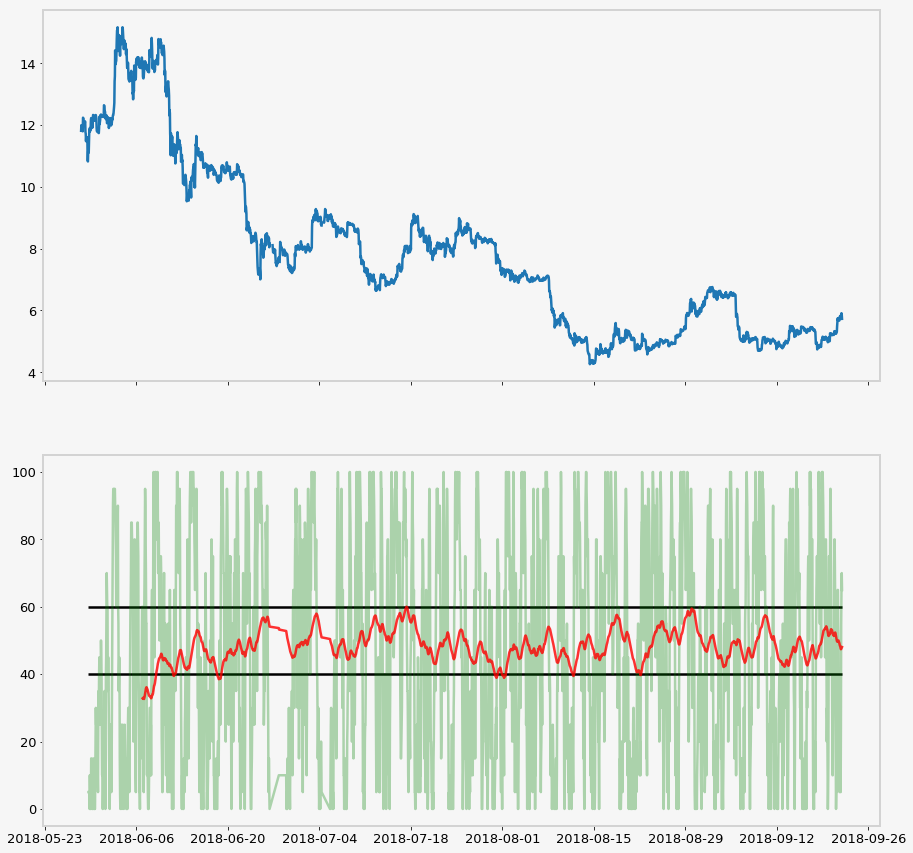

In [62]:
# 3、绘图观察
import matplotlib.pyplot as plt
from talib import abstract

fig, (ax,ax1) = plt.subplots(2,1,sharex=True, figsize=(15,15))
ax.plot(dv.get_ts('close',date_type='datetime'))
ax1.plot(signalDf['signal'], 'g', alpha=0.3)
ax1.plot(abstract.EMA(signalDf,200,price='signal'), 'r', alpha=0.8)
ax1.hlines(60, signalDf['signal'].index[0], signalDf['signal'].index[-1])
ax1.hlines(40, signalDf['signal'].index[0], signalDf['signal'].index[-1])
plt.show()

In [63]:
#4、定义信号事件
def signalAppend(signalDf):
    signalDf['time'] = signalDf.index
    signalDf["trade_date"] = signalDf['time'].apply(lambda x:int(x.strftime(format="%Y-%m-%d %H:%M:%S").replace("-","").replace(":","").replace(" ","")))
    signalDf["symbol"] = "BTCUSDT:binance"
    signalDf = signalDf.set_index(["trade_date","symbol"])
    signalSe = signalDf.signal.unstack()
    dv.append_df(signalSe,'signalSe')
signalAppend(signalDf)

In [64]:
# 5、设定进出场条件
long = dv.add_formula('long','If((signalSe>=60) && (Delay(signalSe,1)<60), 2, 0)', add_data=True)
short = dv.add_formula('short','If((signalSe<=40) && (Delay(signalSe,1)>40), -2, 0)', add_data=True)
closeLong = dv.add_formula('closeLong','If(short==-2,1,0)', add_data=True)
closeShort = dv.add_formula("closeShort",'If(long==2,-1,0)', add_data=True)

D:\python\Anaconda_\lib\site-packages\jaqs\data\py_expression_eval.py:495: RuntimeWarning: invalid value encountered in greater_equal
  res = arr >= brr
D:\python\Anaconda_\lib\site-packages\jaqs\data\py_expression_eval.py:486: RuntimeWarning: invalid value encountered in less
  res = arr < brr
D:\python\Anaconda_\lib\site-packages\jaqs\data\py_expression_eval.py:504: RuntimeWarning: invalid value encountered in less_equal
  res = arr <= brr
D:\python\Anaconda_\lib\site-packages\jaqs\data\py_expression_eval.py:477: RuntimeWarning: invalid value encountered in greater
  res = arr > brr


In [65]:
#6、计算绩效
from jaqs_fxdayu.research import TimingDigger

tdMaStatistic = TimingDigger(output_folder=".", output_format='pdf',signal_name='MaStatistic')

def TimingSignal(td, dv, mhp=None,sl=None,sp=None):
    # step 1：实例化TimingDigger 通过output_folder和output_format指定测试报告的输出路径和输出格式，通过signal_name指定绩效文件名称


    #多空分别计算一遍 输出汇总结果
    td.process_signal(
        enter_signal=dv.get_ts("long"),
        exit_signal=dv.get_ts("closeLong"),
        sig_type="long",  # 信号类型 long
        price=dv.get_ts("close"),
        max_holding_period=mhp,  # 最大持有天数 可为空
        stoploss=-sl,  # 止损百分比 负数 可为空
        stopprofit=sp,  # 止盈百分比 正数 可为空
    )

    td.process_signal(
        enter_signal=dv.get_ts("short"),
        exit_signal=dv.get_ts("closeShort"),
        sig_type="short",  # 信号类型 short
        price=dv.get_ts("close"),
        max_holding_period=mhp,  # 最大持有天数 可为空
        stoploss=-sl,  # 止损百分比 负数 可为空
        stopprofit=sp,  # 止盈百分比 正数 可为空
    )
TimingSignal(tdMaStatistic, dv, 100, 0.15, 0.7)

D:\python\Anaconda_\lib\site-packages\jaqs_fxdayu\research\timingdigger\digger.py:58: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
  return x.loc[exit_pos[x.name]].values


Nan Data Count (should be zero) : 0;  Percentage of effective data: 6%
Nan Data Count (should be zero) : 0;  Percentage of effective data: 6%


In [66]:
tdMaStatistic.create_event_report(sig_type="long")

*****-Summary-*****
Event Analysis
                       win    loss      all
t-stat               5.533  -8.939   -1.752
p-value              0.000   0.000    0.082
mean                 0.028  -0.029   -0.006
std                  0.040   0.031    0.045
info_ratio           0.708  -0.927   -0.141
skewness             2.662  -1.457    0.818
kurtosis             7.900   1.237    4.960
pct5                 0.001  -0.097   -0.085
pct25                0.005  -0.038   -0.023
pct50                0.014  -0.016   -0.006
pct75                0.030  -0.007    0.007
pct95                0.118  -0.001    0.053
occurance           62.000  94.000  156.000
win_ratio              NaN     NaN    0.397
win_mean/loss_mean     NaN     NaN    0.970


In [67]:
tdMaStatistic.create_event_report(sig_type="short")

*****-Summary-*****
Event Analysis
                       win    loss      all
t-stat               7.831 -10.969    0.426
p-value              0.000   0.000    0.670
mean                 0.035  -0.025    0.001
std                  0.038   0.022    0.043
info_ratio           0.904  -1.131    0.033
skewness             1.300  -1.318    0.950
kurtosis             0.426   1.235    1.676
pct5                 0.001  -0.070   -0.063
pct25                0.007  -0.032   -0.022
pct50                0.016  -0.019   -0.003
pct75                0.048  -0.009    0.015
pct95                0.121  -0.001    0.097
occurance           76.000  95.000  171.000
win_ratio              NaN     NaN    0.444
win_mean/loss_mean     NaN     NaN    1.374


In [68]:
tdMaStatistic.create_event_report(sig_type="long_short")#同时计算多空头信号的绩效

*****-Summary-*****
Event Analysis
                        win     loss      all
t-stat                9.498  -13.647   -0.941
p-value               0.000    0.000    0.347
mean                  0.032   -0.027   -0.002
std                   0.039    0.027    0.044
info_ratio            0.811   -0.995   -0.052
skewness              1.925   -1.538    0.859
kurtosis              3.784    1.900    3.381
pct5                  0.001   -0.086   -0.072
pct25                 0.007   -0.035   -0.022
pct50                 0.015   -0.018   -0.004
pct75                 0.041   -0.008    0.010
pct95                 0.120   -0.001    0.085
occurance           138.000  189.000  327.000
win_ratio               NaN      NaN    0.422
win_mean/loss_mean      NaN      NaN    1.170
